
<img src="../../img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Автор материала: Юрий Кашницкий (@yorko в Slack ODS). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание 6 (демо). Линейная регрессия, Lasso и RF-регрессия в задаче по определению качества вина</center>
<img src='../../img/wine_quality.jpg' width=30%>

**Заполните пропущенный код и ответьте на вопросы в [онлайн-форме](https://docs.google.com/forms/d/1gsNxgkd0VqidZp4lh9mnCQnJw3b0IFR1C4WBES86J40).**

In [9]:
# отключим всякие предупреждения Anaconda
import warnings

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split)
from sklearn.preprocessing import StandardScaler

**Будем работать с набором данных по качеству белого вина (репозиторий UCI).**
**Загружаем данные.**

In [3]:
data = pd.read_csv('../../data/winequality-white.csv', sep=';')

In [4]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


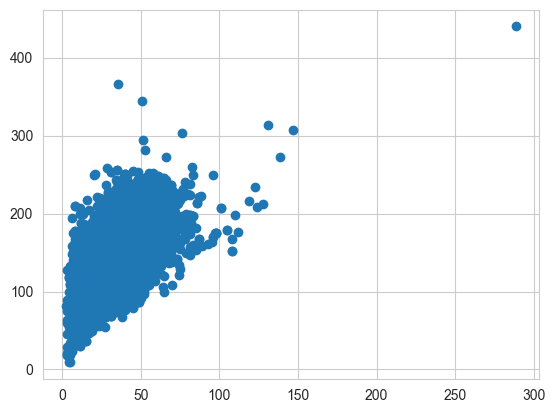

In [11]:
plt.scatter(data["free sulfur dioxide"], data["total sulfur dioxide"])

<Axes: >

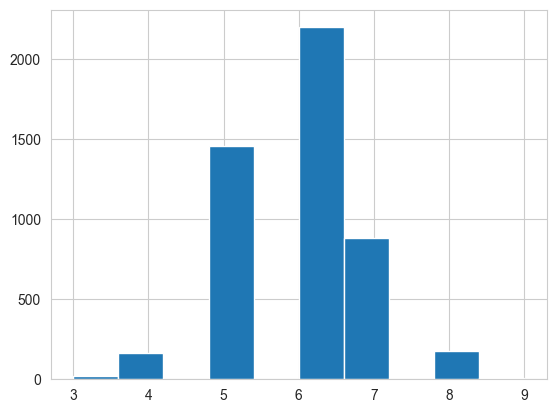

In [21]:
data["quality"].hist()

**Отделите целевой признак, разделите обучающую выборку в отношении 7:3 (30% - под оставленную выборку, пусть random_state=17) и отмасштабируйте данные с помощью StandardScaler.**

In [41]:
y = data["quality"]
X = data.drop("quality", axis=1)

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=17)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_holdout_scaled = scaler.transform(X_holdout)

## Линейная регрессия

**Обучите простую линейную регрессию.**

In [42]:
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

LinearRegression()

**<font color='red'>Вопрос 1:</font> Каковы среднеквадратичные ошибки линейной регрессии на обучающей и отложенной выборках?**

In [43]:
print("Mean squared error (train): %.3f" % mean_squared_error(linreg.predict(X_train_scaled), y_train))
print("Mean squared error (test): %.3f" % mean_squared_error(linreg.predict(X_holdout_scaled), y_holdout))

Mean squared error (train): 0.558
Mean squared error (test): 0.584


In [45]:
pd.DataFrame({
    "prediction" : linreg.predict(X_holdout_scaled),
    "real" : y_holdout
}).sort_index()

,prediction,real
0,5.511540,6
3,5.810922,6
7,5.511540,6
8,5.209599,6
13,6.779778,7
...,...,...
4887,6.316185,7
4890,6.214723,6
4895,5.328132,6
4896,6.615978,7


**Посмотрите на коэффициенты модели и отранжируйте признаки по влиянию на качество вина (учтите, что большие по модулю отрицательные значения коэффициентов тоже говорят о сильном влиянии). Создайте для этого новый небольшой DataFrame.**<br>
**<font color='red'>Вопрос 2:</font> Какой признак линейная регрессия считает наиболее сильно влияющим на качество вина?**

In [79]:
data.columns.drop("quality")

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [83]:
linreg_coef = pd.DataFrame({
    "coefs" : linreg.coef_,
    "coefs_abs" : np.abs(linreg.coef_)},
     index=data.columns.drop("quality"))
linreg_coef.sort_values(by="coefs_abs", ascending=False)

,coefs,coefs_abs
density,-0.665720,0.665720
residual sugar,0.538164,0.538164
volatile acidity,-0.192260,0.192260
pH,0.150036,0.150036
alcohol,0.129533,0.129533
fixed acidity,0.097822,0.097822
sulphates,0.062053,0.062053
free sulfur dioxide,0.042180,0.042180
total sulfur dioxide,0.014304,0.014304
chlorides,0.008127,0.008127


## Lasso-регрессия

**Обучите Lasso-регрессию с небольшим коэффициентом $\alpha = 0.01$ (слабая регуляризация). Пусть опять random_state=17.**

In [84]:
lasso1 = Lasso(alpha=0.01, random_state=17)
lasso1.fit(X_train_scaled, y_train)

Lasso(alpha=0.01, random_state=17)

**Посмотрите на коэффициенты модели и отранжируйте признаки по влиянию на качество вина. Какой признак "отвалился" первым, то есть наименее важен для объяснения целевого признака в модели Lasso?**

In [87]:
lasso1_coef = pd.DataFrame({
    "coefs" : lasso1.coef_,
    "coefs_abs" : np.abs(lasso1.coef_)
}, index=data.columns.drop("quality"))
lasso1_coef.sort_values(by="coefs_abs", ascending=False)

,coefs,coefs_abs
alcohol,0.322425,0.322425
residual sugar,0.256363,0.256363
density,-0.235492,0.235492
volatile acidity,-0.188479,0.188479
pH,0.067277,0.067277
free sulfur dioxide,0.043088,0.043088
sulphates,0.029722,0.029722
chlorides,-0.002747,0.002747
fixed acidity,-0.000000,0.000000
citric acid,-0.000000,0.000000


**Теперь определите лучшее значение $\alpha$ в процессе кросс-валидации 5-кратной кросс-валидации. Используйте LassoCV и random_state=17.**

In [90]:
%%time
alphas = np.logspace(-6, 2, 200)
lasso_cv = LassoCV(random_state=17, cv=5, alphas=alphas, n_jobs=-1)
lasso_cv.fit(X_train_scaled, y_train)

CPU times: total: 234 ms
Wall time: 218 ms


LassoCV(alphas=array([1.00000000e-06, 1.09698580e-06, 1.20337784e-06, 1.32008840e-06,
       1.44811823e-06, 1.58856513e-06, 1.74263339e-06, 1.91164408e-06,
       2.09704640e-06, 2.30043012e-06, 2.52353917e-06, 2.76828663e-06,
       3.03677112e-06, 3.33129479e-06, 3.65438307e-06, 4.00880633e-06,
       4.39760361e-06, 4.82410870e-06, 5.29197874e-06, 5.80522552e-06,
       6.36824994e-06, 6.98587975e-0...
       1.18953407e+01, 1.30490198e+01, 1.43145894e+01, 1.57029012e+01,
       1.72258597e+01, 1.88965234e+01, 2.07292178e+01, 2.27396575e+01,
       2.49450814e+01, 2.73644000e+01, 3.00183581e+01, 3.29297126e+01,
       3.61234270e+01, 3.96268864e+01, 4.34701316e+01, 4.76861170e+01,
       5.23109931e+01, 5.73844165e+01, 6.29498899e+01, 6.90551352e+01,
       7.57525026e+01, 8.30994195e+01, 9.11588830e+01, 1.00000000e+02]),
        cv=5, n_jobs=-1, random_state=17)

In [91]:
lasso_cv.alpha_

0.0002833096101839324

**Выведите коэффициенты "лучшего" Lasso в порядке убывания влияния на качество вина. **<br>
**<font color='red'>Вопрос 3:</font> Какой признак "обнулился первым" в настроенной модели LASSO?**

In [92]:
lasso_cv_coef = pd.DataFrame({
    "coefs" : lasso_cv.coef_,
    "coefs_abs" : np.abs(lasso_cv.coef_)
}, index=data.columns.drop("quality"))
lasso_cv_coef.sort_values(by="coefs_abs", ascending=False)

,coefs,coefs_abs
density,-0.648161,0.648161
residual sugar,0.526883,0.526883
volatile acidity,-0.192049,0.192049
pH,0.146549,0.146549
alcohol,0.137115,0.137115
fixed acidity,0.093295,0.093295
sulphates,0.060939,0.060939
free sulfur dioxide,0.042698,0.042698
total sulfur dioxide,0.012969,0.012969
chlorides,0.006933,0.006933


**Оцените среднеквадратичную ошибку модели на обучающей и тестовой выборках.**<br>
**<font color='red'>Вопрос 4:</font> Каковы среднеквадратичные ошибки настроенной LASSO-регрессии на обучающей и отложенной выборках?**

In [94]:
print("Mean squared error (train): %.3f" % mean_squared_error(lasso_cv.predict(X_train_scaled), y_train))
print("Mean squared error (test): %.3f" % mean_squared_error(lasso_cv.predict(X_holdout_scaled), y_holdout))

Mean squared error (train): 0.558
Mean squared error (test): 0.583


## Случайный лес

**Обучите случайный лес с параметрами "из коробки", фиксируя только random_state=17.**

In [95]:
forest = RandomForestRegressor(random_state=17)
forest.fit(X_train, y_train)

RandomForestRegressor(random_state=17)

**<font color='red'>Вопрос 5:</font> Каковы среднеквадратичные ошибки случайного леса на обучающей выборке, на кросс-валидации (cross_val_score с scoring='neg_mean_squared_error' и остальными параметрами по умолчанию) и на отложенной выборке?**

In [98]:
print("Mean squared error (train): %.3f" % mean_squared_error(forest.predict(X_train), y_train))
print("Mean squared error (cv): %.3f" % np.abs(np.mean(cross_val_score(forest, X_train, y_train, cv=5, scoring="neg_mean_squared_error"))))
print("Mean squared error (test): %.3f" % mean_squared_error(forest.predict(X_holdout), y_holdout))

Mean squared error (train): 0.053
Mean squared error (cv): 0.414
Mean squared error (test): 0.371


**Настройте параметры min_samples_leaf и max_depth с помощью GridSearchCV и опять проверьте качество модели на кросс-валидации и на отложенной выборке.**

In [99]:
forest_params = {'max_depth': list(range(10, 25)), 
                 'min_samples_leaf': list(range(1, 8)),
                 'max_features': list(range(6,12))}

locally_best_forest = GridSearchCV(RandomForestRegressor(random_state=17, n_jobs=-1),
                                   forest_params,
                                   cv=5,
                                   scoring="neg_mean_squared_error",
                                   verbose=1,
                                   n_jobs=-1)
locally_best_forest.fit(X_train, y_train)

Fitting 5 folds for each of 630 candidates, totalling 3150 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                       20, 21, 22, 23, 24],
                         'max_features': [6, 7, 8, 9, 10, 11],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7]},
             scoring='neg_mean_squared_error', verbose=1)

In [100]:
locally_best_forest.best_params_

{'max_depth': 21, 'max_features': 6, 'min_samples_leaf': 1}

In [101]:
locally_best_forest.best_params_, locally_best_forest.best_score_

({'max_depth': 21, 'max_features': 6, 'min_samples_leaf': 1},
 -0.3978585793392684)

**К сожалению, результаты  GridSearchCV не полностью воспроизводимы (могут отличаться на разных платформах даже при фиксировании *random_state*). Поэтому обучите лес с параметрами max_depth=19, max_features=7, и min_samples_leaf=1 (лучшие в моем случае).**<br>
**<font color='red'>Вопрос 6:</font> Каковы среднеквадратичные ошибки настроенного случайного леса на обучающей выборке, на кросс-валидации (cross_val_score с scoring='neg_mean_squared_error') и на отложенной выборке?**

In [104]:
print("Mean squared error (cv): %.3f" % np.abs(np.mean(cross_val_score(locally_best_forest.best_estimator_,
                                                                       X_train,
                                                                       y_train,
                                                                       cv=5,
                                                                       scoring="neg_mean_squared_error"))))
print("Mean squared error (test): %.3f" % mean_squared_error(locally_best_forest.best_estimator_.predict(X_holdout),
                                                             y_holdout))

Mean squared error (cv): 0.398
Mean squared error (test): 0.366


**Оцените важность признаков с помощью случайного леса.**<br>
**<font color='red'>Вопрос 7:</font> Какой признак оказался главным в настроенной модели случайного леса?**

In [106]:
best_forest = locally_best_forest.best_estimator_

In [109]:
rf_importance = pd.DataFrame(best_forest.feature_importances_, columns=["coef"], index=data.columns[:-1])
rf_importance.sort_values(by="coef", ascending=False)

,coef
alcohol,0.206056
volatile acidity,0.117578
free sulfur dioxide,0.111556
density,0.088549
pH,0.073659
total sulfur dioxide,0.073640
chlorides,0.073366
residual sugar,0.072072
citric acid,0.062601
fixed acidity,0.061813


**Сделайте выводы о качестве моделей и оценках влияния признаков на качество вина с помощью этих трех моделей.**